In [100]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn

from pytorch_lightning.metrics.functional import accuracy

import matplotlib.pyplot as plt

In [101]:
batch_size_train = 32
batch_size_val = 1000
batch_size_test = 1000

In [102]:
# load the MNIST dataset
# the global mean and standard deviation of the MNIST dataset - 0.1307 and 0.3081 
# accordingly are used for data normalization 

train_dataset = torchvision.datasets.MNIST('/files/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# split train_dataset into train and validation datasets 
# create corresponding instances of DataLoader class

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, 
                                                         [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

In [105]:
# define a model

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=2, stride=2, padding=0)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv5 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = torch.nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=0)
    
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = torch.nn.Linear(128*1*1, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.fc3 = torch.nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.conv6(x))
        
        x = self.pool3(x)
   
        x = x.view(-1, 128*1*1)
   
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [113]:
# a function that runs a training process for the neural network


def train(model, train_loader):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)    
    # to reduce learning rate on plateau the corresponding scheduler is applied
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)
    
    epochs = 12
    epoch_loss = [0]*epochs
    epoch_accuracy = [0]*epochs
        
    train_losses = []
    train_counter = []
    log_interval = 15
    
    for e in range(epochs):
        running_loss = 0
        running_accuracy = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
          
            optimizer.zero_grad()
        
            output = model(images)
            loss = loss_fn(output, labels)
        
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % log_interval == 0:
                train_losses.append(loss.item())
                train_counter.append((batch_idx*batch_size_train) + (e*len(train_loader.dataset)))
                
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)
        
        val_loss, val_acc = test(model, val_loader)
        scheduler.step(val_loss)
            
        epoch_loss[e] = running_loss/len(train_loader)
        epoch_accuracy[e] = running_accuracy/len(train_loader)
        
        print("Epoch {} \n Training: loss - {}, accuracy - {} \n Validation: loss - {}, accuracy - {}"
              .format(e, epoch_loss[e], epoch_accuracy[e], val_loss, val_acc))
        
    
    fig, (ax1, ax2) = plt.subplots(1,2)

    fig.set_figwidth(20)
    fig.set_figheight(7)

    ax1.plot(range(epochs), epoch_loss)
    ax2.plot(train_counter, train_losses)
    
    ax1.set(xlabel="Epoch", ylabel="Loss")
    ax2.set(xlabel="Number of training examples seen", ylabel="Loss")


In [104]:
# this function calculates a loss value and prediction accuracy
# on the validation dataset

def test(model, val_loader):
    
    running_loss = 0
    running_accuracy = 0
    
    for images, labels in val_loader:
        with torch.no_grad():
            
            output = model(images)
            
            running_loss += loss_fn(output, labels)
            running_accuracy += accuracy(F.softmax(output, dim=1), labels)
            
    running_loss /= len(val_loader)
    running_accuracy /= len(val_loader)
    
    return running_loss, running_accuracy

In [106]:
loss_fn = nn.CrossEntropyLoss()

Epoch 0 
 Training: loss - 0.1708425609733056, accuracy - 0.9534549117088318 
 Validation: loss - 0.05461393669247627, accuracy - 0.9842000007629395
Epoch 1 
 Training: loss - 0.05903137953456203, accuracy - 0.9830654263496399 
 Validation: loss - 0.04248723387718201, accuracy - 0.987500011920929
Epoch 2 
 Training: loss - 0.047025819172232426, accuracy - 0.9864243268966675 
 Validation: loss - 0.04175136610865593, accuracy - 0.9879999160766602
Epoch 3 
 Training: loss - 0.03635476993926296, accuracy - 0.9897632598876953 
 Validation: loss - 0.032565198838710785, accuracy - 0.9904998540878296
Epoch 4 
 Training: loss - 0.034155196974166295, accuracy - 0.990303099155426 
 Validation: loss - 0.03465449437499046, accuracy - 0.9901000261306763
Epoch 5 
 Training: loss - 0.02774638016217359, accuracy - 0.9921424984931946 
 Validation: loss - 0.03321416303515434, accuracy - 0.9905999302864075
Epoch 6 
 Training: loss - 0.015330494077563685, accuracy - 0.9958013296127319 
 Validation: loss - 

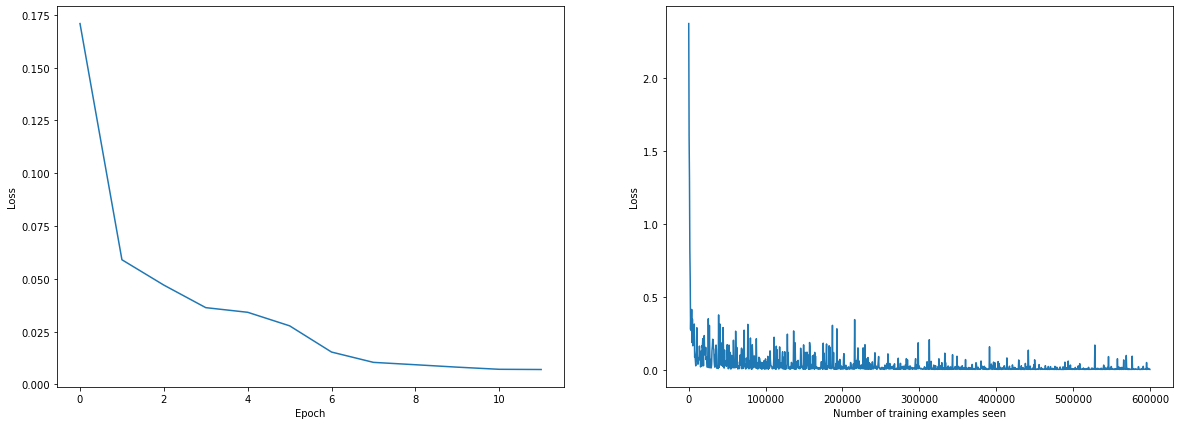

In [114]:
model = Model()  

train(model, train_loader)

In [115]:
test_loss, test_acc = test(model, test_loader)

print("Test loss: {} - Test accuracy: {}".format(test_loss, test_acc))

Test loss: 0.01800067350268364 - Test accuracy: 0.9951000213623047
